In [1]:
import numpy as np # linear algebra
import pandas as pd # data manipulation and analysis
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # data visualization
sns.set_style('whitegrid') # set style for visualization
import warnings # ignore warnings
warnings.filterwarnings('ignore')
import requests, zipfile, io
from sklearn.impute import KNNImputer

# Data Loading and Basic Understanding

In [2]:
# Download and Unzip the Dataset
url = "https://github.com/devtlv/Datasets-DA-Bootcamp-2-/raw/refs/heads/main/Week%205%20-%20Data%20Processing/W5D4%20-%20Mini-project/Palmer%20Penguins%20Dataset.zip"

r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("data")

In [3]:
# Load as Pandas Dataframe
df = pd.read_csv('.\data\Palmer Penguins Dataset.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
 7   year               344 non-null    int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 21.6+ KB


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


In [4]:
# Separate Numeric and Categorical Columns
df_numeric = df.select_dtypes(include=['int64', 'float64'])
df_categorical = df.drop(columns=df_numeric.columns)

# Numeric Columns Details
df.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year
count,342.000000,342.000000,342.000000,342.000000,344.000000
mean,43.921930,17.151170,200.915205,4201.754386,2008.029070
std,5.459584,1.974793,14.061714,801.954536,0.818356
min,32.100000,13.100000,172.000000,2700.000000,2007.000000
25%,39.225000,15.600000,190.000000,3550.000000,2007.000000
50%,44.450000,17.300000,197.000000,4050.000000,2008.000000
75%,48.500000,18.700000,213.000000,4750.000000,2009.000000
max,59.600000,21.500000,231.000000,6300.000000,2009.000000


In [5]:
# Categorical Columns Details
for col in df_categorical:
    print(df_categorical[col].value_counts(dropna=False), '\n')

species
Adelie       152
Gentoo       124
Chinstrap     68
Name: count, dtype: int64 

island
Biscoe       168
Dream        124
Torgersen     52
Name: count, dtype: int64 

sex
male      168
female    165
NaN        11
Name: count, dtype: int64 



# Data Cleaning and EDA

## Missing Values

In [6]:
# Print all Rows with a missing Value
missing_rows = df[df.isnull().any(axis=1)]
print(missing_rows)

# Drop Rows that are missing Critical Data
df = df.drop(index=[3, 271]).reset_index(drop=True)

# Check After
missing_rows = df[df.isnull().any(axis=1)]
print(missing_rows)

    species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
3    Adelie  Torgersen             NaN            NaN                NaN   
8    Adelie  Torgersen            34.1           18.1              193.0   
9    Adelie  Torgersen            42.0           20.2              190.0   
10   Adelie  Torgersen            37.8           17.1              186.0   
11   Adelie  Torgersen            37.8           17.3              180.0   
47   Adelie      Dream            37.5           18.9              179.0   
178  Gentoo     Biscoe            44.5           14.3              216.0   
218  Gentoo     Biscoe            46.2           14.4              214.0   
256  Gentoo     Biscoe            47.3           13.8              216.0   
268  Gentoo     Biscoe            44.5           15.7              217.0   
271  Gentoo     Biscoe             NaN            NaN                NaN   

     body_mass_g  sex  year  
3            NaN  NaN  2007  
8         3475.0  NaN  2007

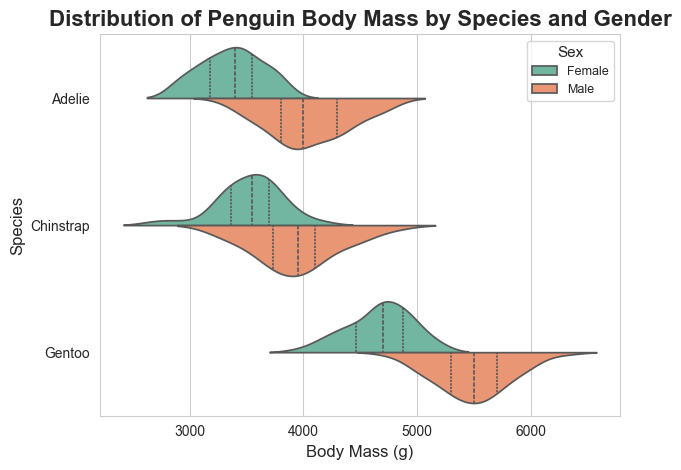

In [19]:
# Visualize the Distribution of Body Mass by the Penguin's 'Species' and 'Sex'
# Violinplot is Simplest Way to Visualize
ax = sns.violinplot(
    data=df,
    x='body_mass_g',
    y='species',
    hue='sex',
    palette='Set2',
    split=True,
    inner='quartile',
    scale='width'
)

# Set title and labels
ax.set_title("Distribution of Penguin Body Mass by Species and Gender", fontsize=16, weight='bold')
ax.set_xlabel("Body Mass (g)", fontsize=12)
ax.set_ylabel("Species", fontsize=12)

# Replace legend labels without changing the data
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ['Female', 'Male'], title='Sex', fontsize=9, title_fontsize=11)

plt.tight_layout()
plt.show()

Based on the distributions, we can safely conclude that Males tend to have higher Body Mass than females, however, Gentoo Penguins have noticeably more mass than the other 2 species, so we will need to take this into account when imputing the missing 'Sex' values. Additionally, all of these distributions are normally distributed, so we can use the mean for our imputation.

In [8]:
# Create Dataframe of the mean Body Mass Grouped by 'Species' and 'Sex'
grouped = df.groupby(['species', 'sex'])['body_mass_g'].mean()

# Create Function for Imputation
def impute_sex(row):
    # Check if the Value in 'Sex' column is missing
    if pd.isnull(row['sex']):

        # Get species-specific means
        species = row['species']
        male_mean = grouped.get((species, 'male'))
        female_mean = grouped.get((species, 'female'))
        
        # Compare distances and assign closest
        return 'male' if abs(row['body_mass_g'] - male_mean) < abs(row['body_mass_g'] - female_mean) else 'female'
    
    return row['sex']

# Apply Imputation Function on 'Sex' Column
df['sex'] = df.apply(impute_sex, axis=1)


# Check
df.info()
print()
print(df['sex'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            342 non-null    object 
 1   island             342 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                342 non-null    object 
 7   year               342 non-null    int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 21.5+ KB

sex
female    173
male      169
Name: count, dtype: int64


## Datatype Conversion

In [9]:
# Convert Sex Column to Numerical
df['sex'] = df['sex'].replace({'male' : 1, 'female' : 0})
df['sex'] = df['sex'].astype(int)

# Check
df['sex'].value_counts()

sex
0    173
1    169
Name: count, dtype: int64

In [10]:
# Convert Categorical Columns
# Loop through each non-numeric column and convert to type category
for col in df.select_dtypes(exclude=['number']).columns:
    df[col] = df[col].astype('category')

In [11]:
# Checking the Final Cleaned Data
for col in df:
    print(df[col].value_counts(dropna=False), '\n')

species
Adelie       151
Gentoo       123
Chinstrap     68
Name: count, dtype: int64 

island
Biscoe       167
Dream        124
Torgersen     51
Name: count, dtype: int64 

bill_length_mm
41.1    7
45.2    6
39.6    5
37.8    5
46.2    5
       ..
51.0    1
53.5    1
51.4    1
51.9    1
55.8    1
Name: count, Length: 164, dtype: int64 

bill_depth_mm
17.0    12
17.9    10
18.6    10
18.5    10
15.0    10
        ..
13.1     1
13.3     1
13.6     1
14.9     1
20.8     1
Name: count, Length: 80, dtype: int64 

flipper_length_mm
190.0    22
195.0    17
187.0    16
193.0    15
210.0    14
191.0    13
215.0    12
197.0    10
196.0    10
185.0     9
198.0     8
216.0     8
208.0     8
220.0     8
181.0     7
192.0     7
230.0     7
212.0     7
186.0     7
184.0     7
189.0     7
188.0     6
217.0     6
201.0     6
214.0     6
213.0     6
222.0     6
199.0     6
203.0     5
219.0     5
194.0     5
180.0     5
209.0     5
221.0     5
218.0     5
228.0     4
178.0     4
200.0     4
202.0     4


# Visualization Tasks

### Species Distribution

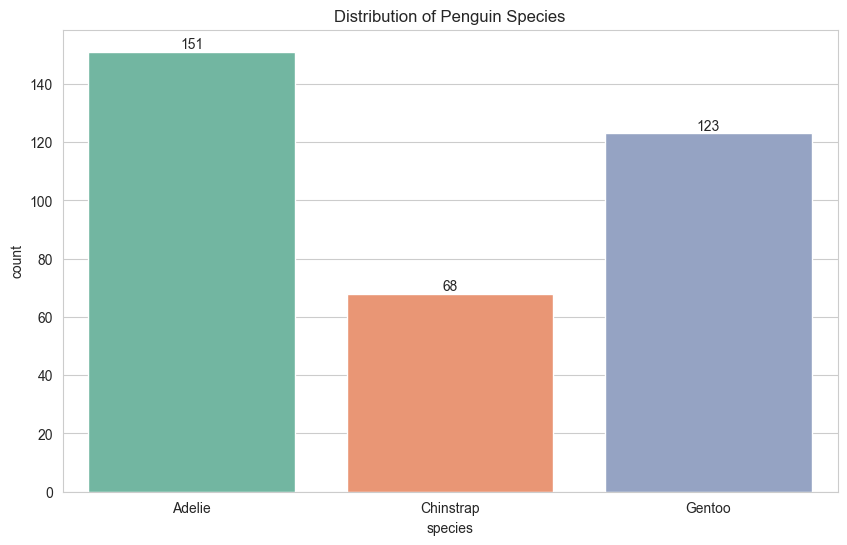

In [12]:
# Use a bar chart to show the distribution of penguin species
plt.figure(figsize=(10,6))
ax = sns.countplot(df, x='species', palette='Set2')

# Add Labels to Each Bar
for container in ax.containers:
    ax.bar_label(container)
    
plt.title('Distribution of Penguin Species')
plt.show()

### Flipper Length vs. Body Mass

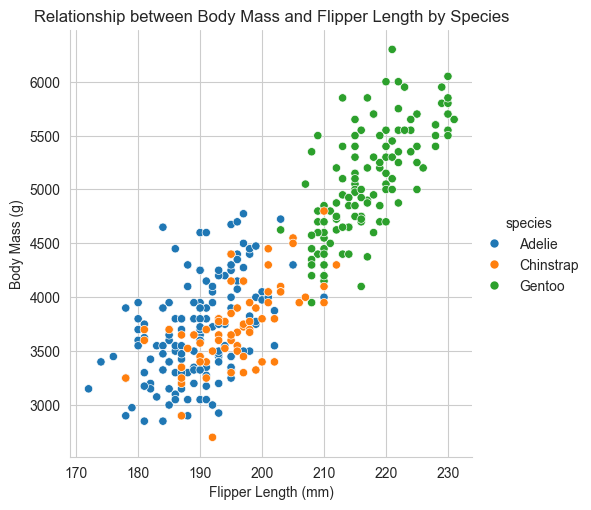

In [13]:
# Create a scatter plot to analyze the relationship between flipper length and body mass, color-coded by species
sns.relplot(df, x='flipper_length_mm', y='body_mass_g', hue='species')
plt.title('Relationship between Body Mass and Flipper Length by Species')
plt.xlabel('Flipper Length (mm)')
plt.ylabel('Body Mass (g)')
plt.show()

From the scatterplot, we can observe that there is a fairly strong positive correlation between the penguin's flipper length and body mass. Additionally, we see again that Gentoo Penguins are noticeably larger in both mass and flipper length than the other 2 species.

### Island Distribution

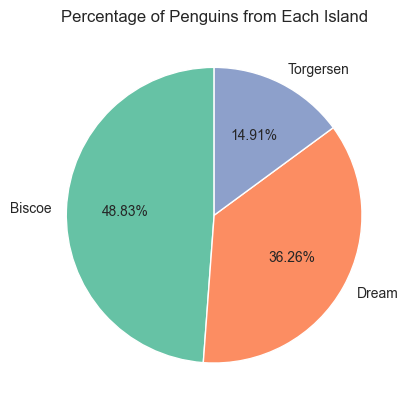

In [14]:
# Visualize the count of penguins on each island using a pie chart
# First, let's count the number of Penguins on each island
island_count = df['island'].value_counts()

# Plot using a Pie Chart
plt.pie(island_count, labels=island_count.index, autopct='%1.2f%%', startangle=90, colors=['#66c2a5','#fc8d62','#8da0cb'])
plt.title('Percentage of Penguins from Each Island')
plt.show()


### Sex Distribution within Species

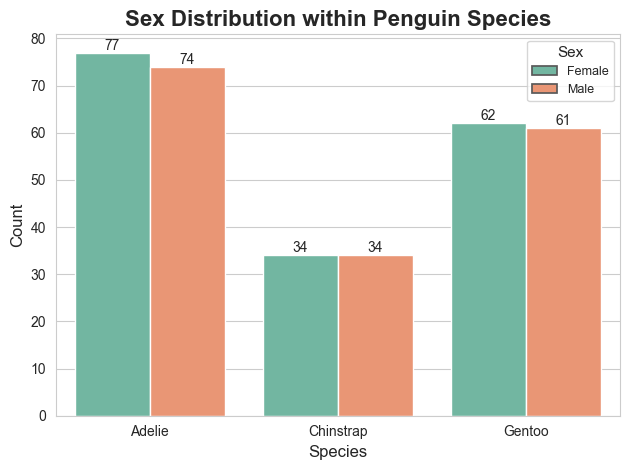

In [15]:
# Create grouped bar charts showing the distribution of sex within each penguin species
ax = sns.countplot(data=df, x='species', hue='sex', palette='Set2')

# Add Labels to Each Bar
for container in ax.containers:
    ax.bar_label(container)

# Titles and labels
ax.set_title("Sex Distribution within Penguin Species", fontsize=16, weight='bold')
ax.set_xlabel("Species", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.legend(handles, ['Female', 'Male'], title='Sex', fontsize=9, title_fontsize=11)

plt.tight_layout()
plt.show()

### Heatmap of Correlations

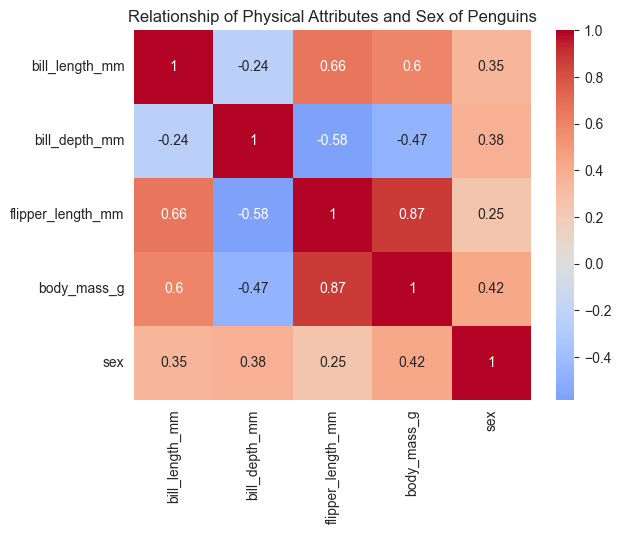

In [16]:
# Plot a heatmap to visualize the correlations between numerical variables
# Create List of Relevant Columns
cols = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex']

# Calculate Correlation Matrix
corr_matrix = df[cols].corr()

# Create Heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Relationship of Physical Attributes and Sex of Penguins')
plt.show()

As we previously observed, there is a strong positive correlation between the flipper/bill meaurements and body mass. However, through the heatmap we can actually observe that there is a fairly strong negative correlation betweem bill depth and body mass as well as flipper length. This means that the smaller the depth of the penguin's bill, the higher its body mass will be.

### Boxplots for Measurements


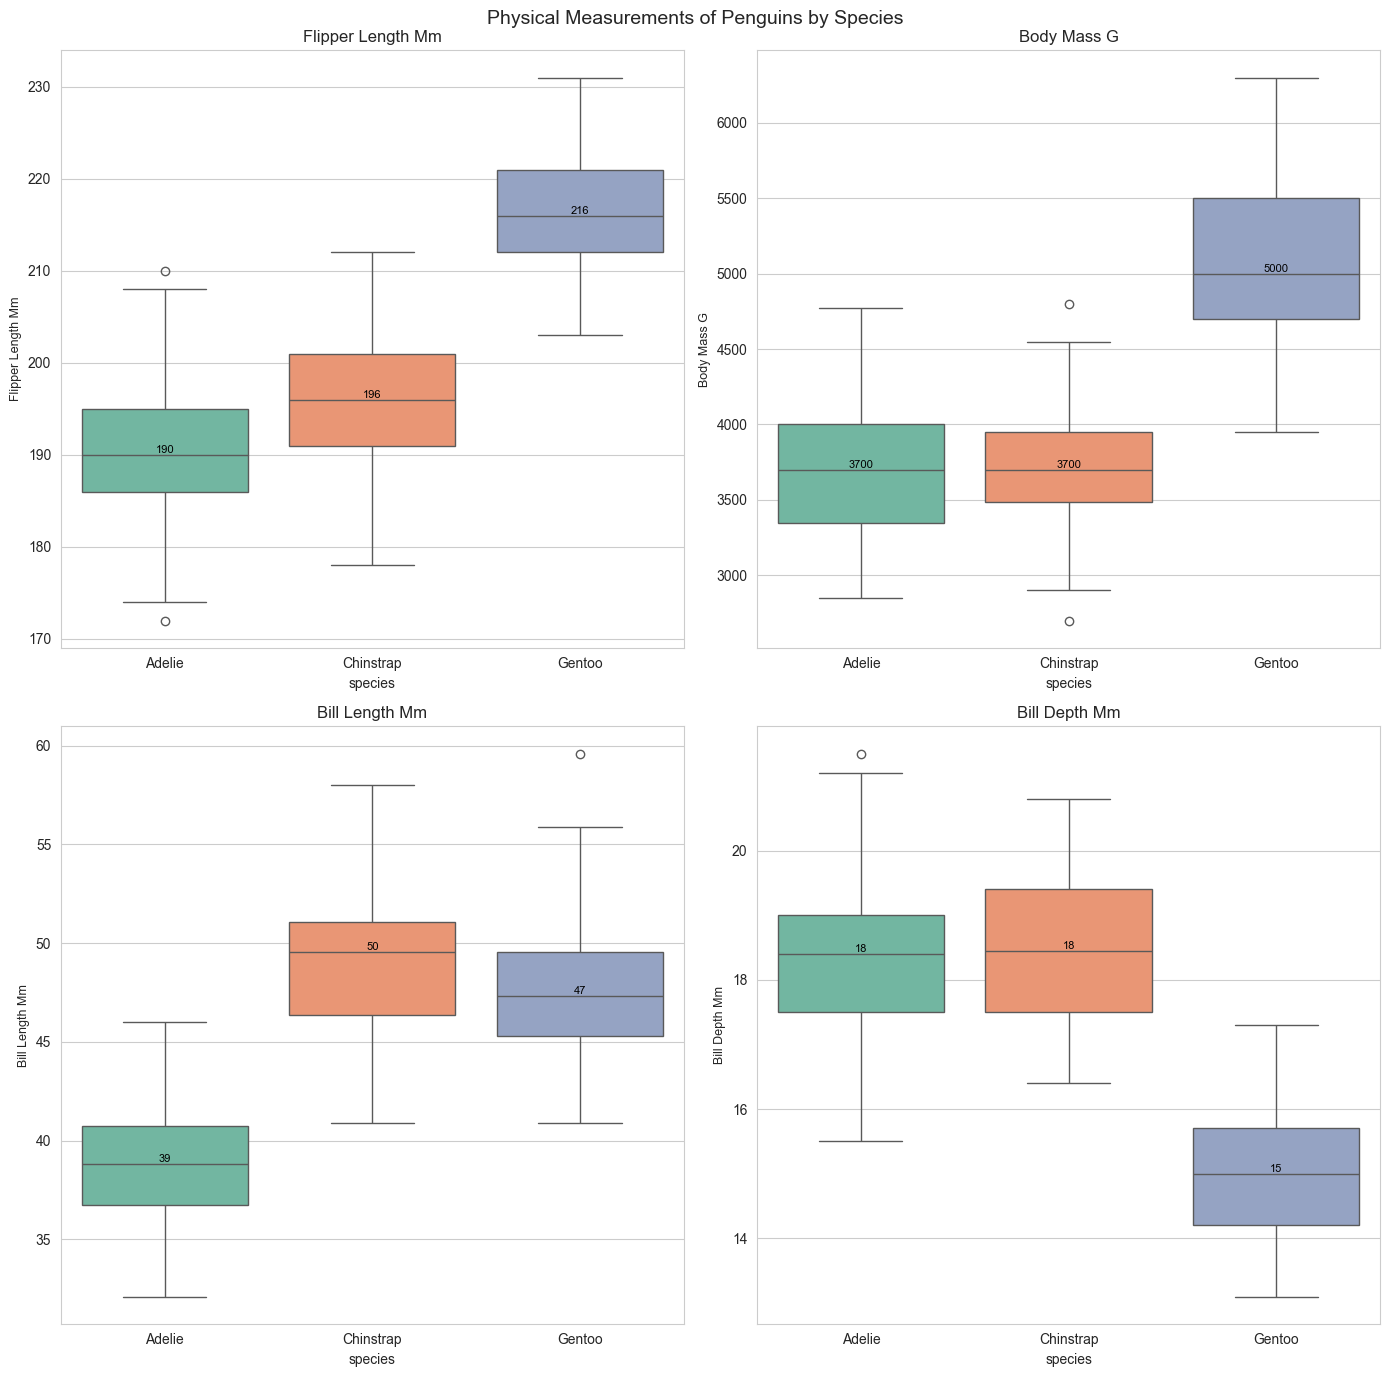

In [17]:
# Create List of Desired Columns/Measurements
cols = ['flipper_length_mm', 'body_mass_g', 'bill_length_mm', 'bill_depth_mm']

# Create Subplot + Dimensions
fig, axes = plt.subplots(2, 2, figsize=(14, 14))
fig.suptitle('Physical Measurements of Penguins by Species', fontsize=14)
axes = axes.flatten()  # flatten for easy iteration

# Use a loop to plot each column as a subplot
for i, col in enumerate(cols):
    ax = axes[i]  # pick the correct subplot
    
    sns.boxplot(
        x='species',
        y=col,
        data=df,
        palette='Set2',
        ax=ax
    )

    # Calculate medians per species for this feature
    medians = df.groupby("species")[col].median()

    # Add median labels
    for j, species in enumerate(medians.index):
        median_val = medians[species]
        ax.text(
            j, median_val, f"{median_val:.0f}",
            ha='center', va='bottom', color='black',
            fontsize=8
        )
    
    # Set Axis Labels and Title
    ax.set_title(f'{col.replace("_"," ").title()}', fontsize=12)
    ax.set_ylabel(col.replace('_', ' ').title(), fontsize=9)
    ax.tick_params(axis='x')  # rotate x-axis labels if needed

plt.tight_layout()
plt.show()

Here we can easily observe the inverse relationship between bill depth and body mass. The Gentoo Penguin is larger than the other 2 species, and it has a much smaller bill depth than the other two. We can also observe that flipper length seems to be the largest determinant of the penguin's size, which was also confirmed by the heatmap seeing as their correlation is 0.87.

## Pairplot

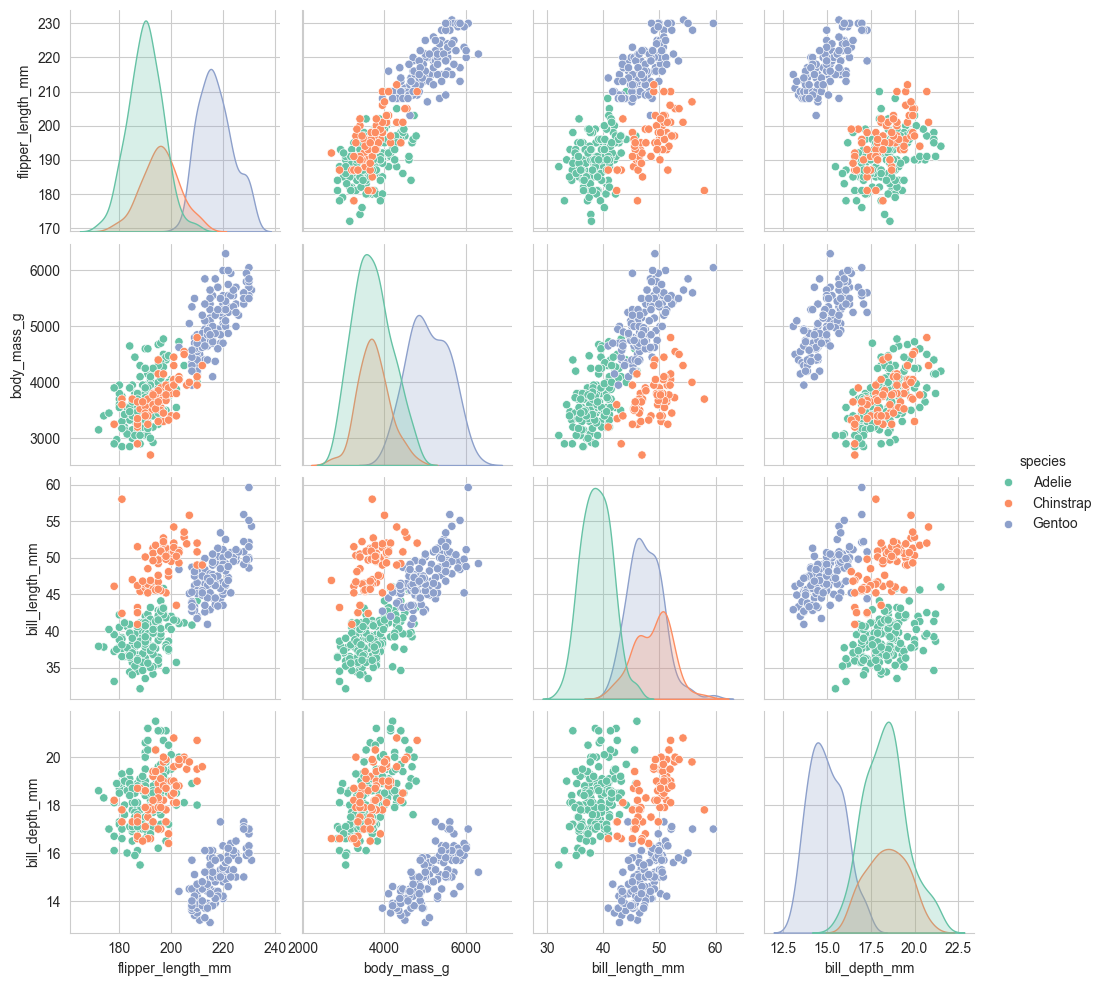

In [18]:
# Create a Pairplot of Numeric Values
sns.pairplot(
    df,
    vars=["flipper_length_mm", "body_mass_g", "bill_length_mm", "bill_depth_mm"],
    hue="species",
    palette="Set2",
    diag_kind="kde"
)
plt.show()